### Summary

I'll be first implementing the following paper CSRNet: https://arxiv.org/pdf/1802.10062.pdf

In the model architecture, we will be passing the image through four additional layers of convolutions (dilated) after first passing it through the standard VGG-16 backbone. This output is passed through one of the four configurations and finally through a 1 x 1 x 1 convolution layer. We will be using the A configuration as it is the smallest.

Next, we perform Mean Squared Error (MSE) loss minimization on the output image to arrive at the optimal weight values while keeping track of the actual crowd count using MAE.

### Import relevant packages and dataset

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from torch_snippets import *
import h5py
from scipy import io

In [2]:
part_A = Glob('./data/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');
image_folder = './data/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
heatmap_folder = './data/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = './data/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

### Defining the training and validation datasets and dataloader

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([T.ToTensor()])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems
        
    def __len__(self):
        return len(self.stems)
    
    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'
        
        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])
        
        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts
    
    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)
    
    def choose(self):
        return self[randint(len(self))]

In [4]:
from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [5]:
for x in trn_dl:
    print(x)
    break

(
    tensor[1, 3, 681, 1024] n=2092032 x∈[0., 1.000] μ=0.552 σ=0.358 cuda:0,
    tensor[1, 1, 85, 128] n=10880 x∈[0., 16.093] μ=0.145 σ=0.645 cuda:0,
    tensor[1] i64 cuda:0 [1591]
)

In [6]:
x

(tensor[1, 3, 681, 1024] n=2092032 x∈[0., 1.000] μ=0.552 σ=0.358 cuda:0,
 tensor[1, 1, 85, 128] n=10880 x∈[0., 16.093] μ=0.145 σ=0.645 cuda:0,
 tensor[1] i64 cuda:0 [1591])

In [7]:
import torch.nn as nn
import torch
from torchvision import models
# from utils import save_net,load_net

def make_layers(cfg, in_channels = 3, batch_norm=False, dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels,v,kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [8]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self.__initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
                
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    
    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init_constant_(m.bias, 0)

In [9]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [10]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')
        
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

EPOCH: 1.000  val_loss: 0.037  val_pts_loss: 385.947  trn_pts_loss: 444.798  trn_loss: 0.054  (224.00s - 4255.99s remaining)
EPOCH: 2.000  val_loss: 0.035  val_pts_loss: 320.389  trn_pts_loss: 319.982  trn_loss: 0.046  (413.21s - 3718.86s remaining)
EPOCH: 3.000  val_loss: 0.030  val_pts_loss: 175.064  trn_pts_loss: 241.029  trn_loss: 0.041  (600.26s - 3401.46s remaining)
EPOCH: 4.000  val_loss: 0.029  val_pts_loss: 174.450  trn_pts_loss: 167.897  trn_loss: 0.038  (774.76s - 3099.03s remaining)
EPOCH: 5.000  val_loss: 0.028  val_pts_loss: 163.566  trn_pts_loss: 150.801  trn_loss: 0.036  (945.78s - 2837.35s remaining)
EPOCH: 6.000  val_loss: 0.028  val_pts_loss: 147.574  trn_pts_loss: 151.450  trn_loss: 0.035  (1118.94s - 2610.86s remaining)
EPOCH: 7.000  val_loss: 0.028  val_pts_loss: 162.900  trn_pts_loss: 151.312  trn_loss: 0.035  (1281.69s - 2380.28s remaining)
EPOCH: 8.000  val_loss: 0.026  val_pts_loss: 157.907  trn_pts_loss: 143.664  trn_loss: 0.034  (1445.67s - 2168.50s remainin

data\shanghaitech_with_people_density_map\ShanghaiTech\part_A\test_data\images\IMG_5.jpg

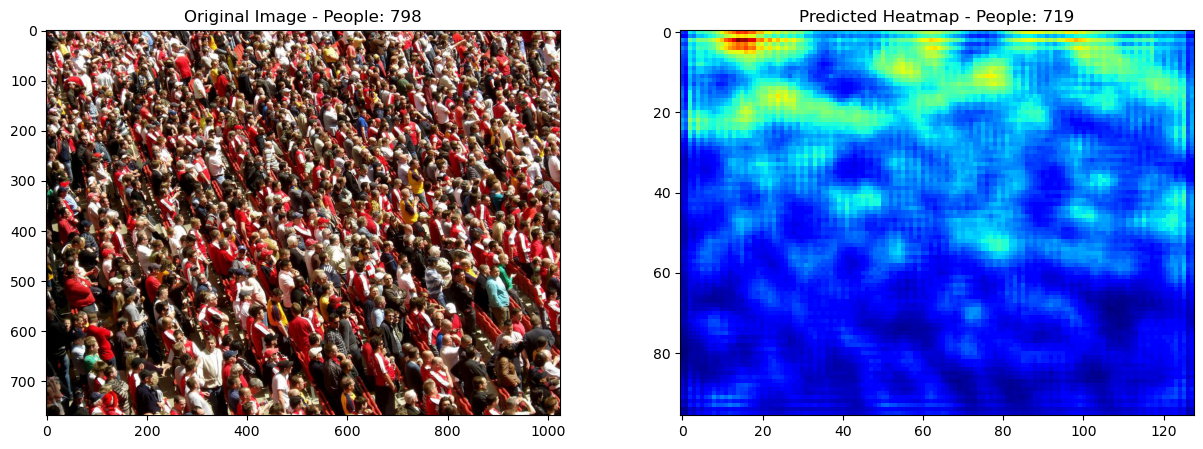

In [11]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
transform=transforms.Compose([
    transforms.ToTensor(),transforms.Normalize(\
        mean=[0.485, 0.456, 0.406],\
        std=[0.229, 0.224, 0.225]),\
    ])
test_folder = './data/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)

# Load original image and ground truth
original_img = Image.open(f).convert('RGB')
original_gt_path = os.path.join(test_folder, 'ground-truth-h5', os.path.splitext(os.path.basename(f))[0] + '.h5')
with h5py.File(original_gt_path, 'r') as hf:
    original_gt = hf['density'][:]
    
# Transform and predict on image
img = transform(original_img).to(device)
output = model(img[None])
predicted_count = int(output.detach().cpu().sum().numpy())
predicted_heatmap = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))

# Display images and counts
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Display original image with ground truth
axs[0].imshow(original_img)
axs[0].set_title(f'Original Image - People: {int(original_gt.sum())}')

# Display predicted heatmap
axs[1].imshow(predicted_heatmap,cmap = c.jet)
axs[1].set_title(f'Predicted Heatmap - People: {predicted_count}')

plt.show()